# 导入必要的库

我们生成验证码的字符由数字和大小写字母组成。

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
#characters = string.digits +  "ABCDEFGHJKLMNOPQRSTUVWXYZabcdefghijlmnqrty"
characters = string.digits + string.ascii_letters
print(characters,len(characters))

width, height, n_len, n_class = 120, 36, 4, len(characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ 62


# 定义数据生成器
Jay用php写的验证码生成器
生成器出来的验证码有干扰线，需要用depoint函数去除干扰线，现在只执行了一次，可以去除大部分，可以再执行多次，但是这个函数会比较耗时


In [3]:
import requests
from PIL import Image as pilImage
from PIL import  ImageEnhance,ImageFilter
from io import BytesIO
import time
 
host="http://192.168.128.129:8080"
url = host+"/make_captcha.php?code=1234&width=120&height=36"
requests.get(url)
reuse_session = requests.session()

def get_img(code):
    url = host+"/make_captcha.php?code="+code+"&width=120&height=36"
    while True:
        content = reuse_session.get(url)
        if content.status_code != 200:
            time.sleep(1)
            print("get captcha from:%s res:%d"%(url, content.status_code))
            continue
        break
    return content.content
 
thread_hold = 600
def is_white(color):
    #print(color)
    return color > thread_hold

def depoint(img):   #input: gray image
    pixdata = img.load()
    w,h = img.size
    for y in range(1,h-2):
        last_color = sum(pixdata[0,y])
        next_color = sum(pixdata[1,y])

        for x in range(1,w-2):
            up_color  = sum(pixdata[x,y - 1])
            down_color = sum(pixdata[x, y + 1])
            color = next_color
            next_color = sum(pixdata[x+1,y])
            if is_white(color):
                pixdata[x,y]=(255,255,255)
            else:
                if is_white(last_color) and is_white(next_color) or is_white(up_color) and is_white(down_color):
                    pixdata[x,y] = (255,255,255)
            last_color = color
    return img

def gen(batch_size=32, show_img=False):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            while True:
                try:
                    img1 = pilImage.open(BytesIO(get_img(random_str)))
                    #img = gray_image(img)
                    if show_img:
                        plt.imshow(img1)
                        #plt.title(decode(y,i))
                        plt.show()
                    img = depoint(img1)
                    #print(img)
                    #img=img.convert("RGB")
                except Exception as e:
                    print(e)
                    continue
                break
            #print(img)
            X[i] = img
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X,y


# 测试生成器

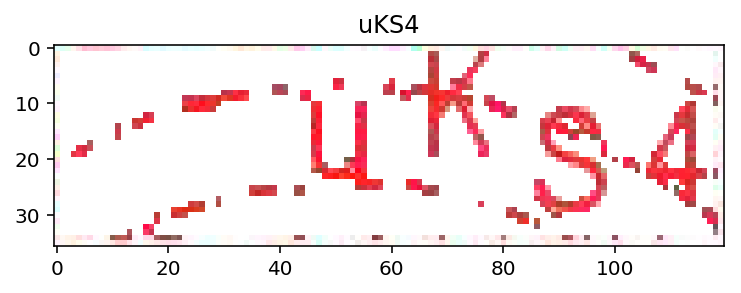

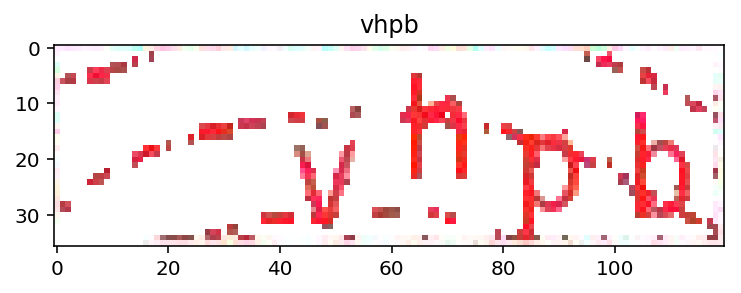

In [5]:
num=2
genImg=gen(num)
def decode(y,i):
    y = np.argmax(np.array(y), axis=2)[:,i]
    return ''.join([characters[x] for x in y])
X, y = next(genImg)
for i in range (num):
    plt.imshow(X[i])
    plt.title(decode(y,i))
    plt.show()
    #print(y)
   # print(X[i])

# 定义网络结构

In [20]:
# CNN
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
#print(x)
for i in range(3):
    x = Conv2D(32*2**i, (3, 5), activation='relu', data_format='channels_last')(x)
    x = Conv2D(32*2**i, (3, 5), activation='relu', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络结构可视化

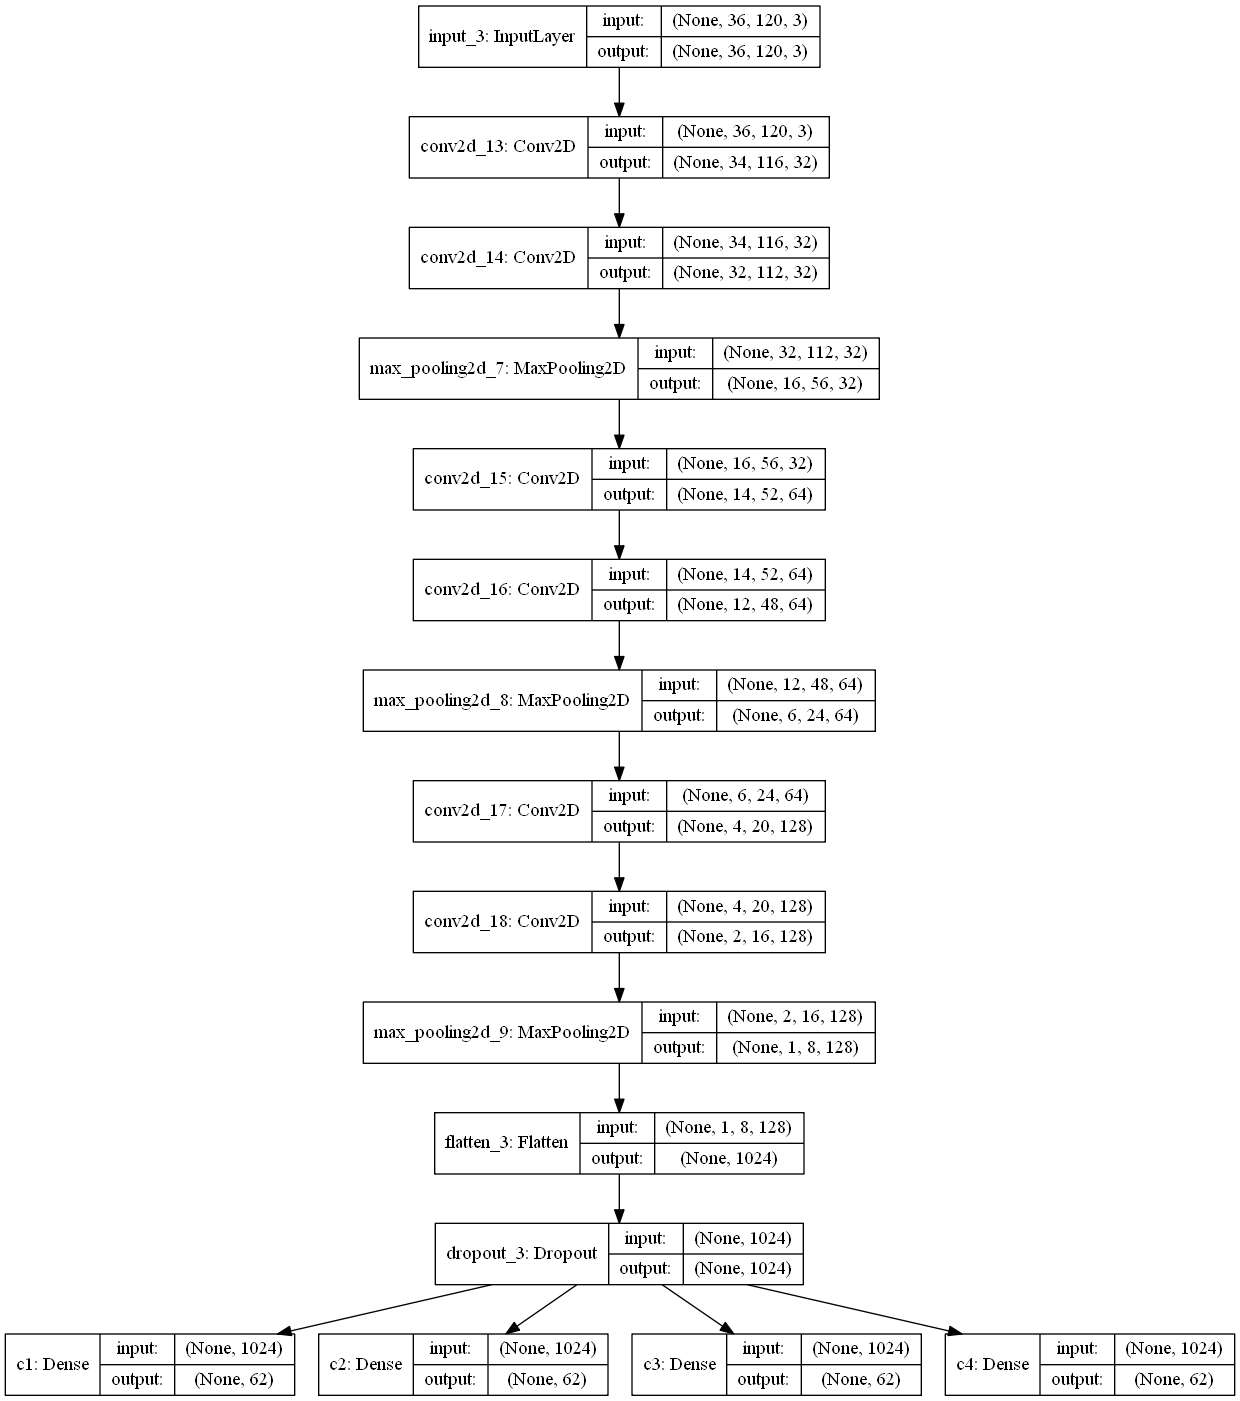

In [21]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [22]:
model.fit_generator(gen(128), steps_per_epoch=500, epochs=10,
                    validation_data=gen(), validation_steps=1280)

Epoch 1/10
500/500 [==============================] - 2888s 6s/step - loss: 16.4648 - c1_loss: 4.1107 - c2_loss: 4.1214 - c3_loss: 4.1282 - c4_loss: 4.1045 - c1_acc: 0.0351 - c2_acc: 0.0340 - c3_acc: 0.0357 - c4_acc: 0.0372 - val_loss: 15.2808 - val_c1_loss: 3.7907 - val_c2_loss: 3.8672 - val_c3_loss: 3.8600 - val_c4_loss: 3.7629 - val_c1_acc: 0.0754 - val_c2_acc: 0.0690 - val_c3_acc: 0.0708 - val_c4_acc: 0.0818
Epoch 2/10
500/500 [==============================] - 3014s 6s/step - loss: 14.2524 - c1_loss: 3.5253 - c2_loss: 3.6062 - c3_loss: 3.6062 - c4_loss: 3.5148 - c1_acc: 0.1147 - c2_acc: 0.1022 - c3_acc: 0.1021 - c4_acc: 0.1189 - val_loss: 12.2141 - val_c1_loss: 3.0394 - val_c2_loss: 3.1067 - val_c3_loss: 3.0932 - val_c4_loss: 2.9747 - val_c1_acc: 0.2024 - val_c2_acc: 0.1766 - val_c3_acc: 0.1825 - val_c4_acc: 0.2217
Epoch 3/10
500/500 [==============================] - 3002s 6s/step - loss: 11.0666 - c1_loss: 2.7273 - c2_loss: 2.8120 - c3_loss: 2.8034 - c4_loss: 2.7238 - c1_acc: 0.

# 保存模型

In [23]:
model.save('cnn_all_letter_conn2d_3_5_depoint.h5')

# 读取模型

In [6]:
from keras.models import load_model
 
model = load_model('cnn_all_letter_conn2d_3_5_depoint.h5')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 精度不足，再训练一轮

In [7]:
model.fit_generator(gen(128), steps_per_epoch=500, epochs=10,
                    validation_data=gen(), validation_steps=1280)

Epoch 1/10
500/500 [==============================] - 985s 2s/step - loss: 1.2286 - c1_loss: 0.3387 - c2_loss: 0.2614 - c3_loss: 0.2498 - c4_loss: 0.3786 - c1_acc: 0.9057 - c2_acc: 0.9308 - c3_acc: 0.9346 - c4_acc: 0.8898 - val_loss: 0.6157 - val_c1_loss: 0.1661 - val_c2_loss: 0.1295 - val_c3_loss: 0.1288 - val_c4_loss: 0.1913 - val_c1_acc: 0.9572 - val_c2_acc: 0.9686 - val_c3_acc: 0.9697 - val_c4_acc: 0.9479
Epoch 2/10
500/500 [==============================] - 946s 2s/step - loss: 1.0303 - c1_loss: 0.2843 - c2_loss: 0.2198 - c3_loss: 0.2065 - c4_loss: 0.3198 - c1_acc: 0.9194 - c2_acc: 0.9397 - c3_acc: 0.9439 - c4_acc: 0.9071 - val_loss: 0.6234 - val_c1_loss: 0.1602 - val_c2_loss: 0.1357 - val_c3_loss: 0.1323 - val_c4_loss: 0.1953 - val_c1_acc: 0.9612 - val_c2_acc: 0.9702 - val_c3_acc: 0.9704 - val_c4_acc: 0.9478
Epoch 3/10
500/500 [==============================] - 953s 2s/step - loss: 0.9818 - c1_loss: 0.2675 - c2_loss: 0.2124 - c3_loss: 0.2013 - c4_loss: 0.3006 - c1_acc: 0.9260 - c

In [8]:
model.save('cnn_all_letter_conn2d_3_5_depoint_20.h5')

In [ ]:
#下一步改进
#二次depoint()
#确认验证码用到的字符(例如数字0和字母O是否都用到，字母I和字母l是否都用到等等)